In [3]:
equilibrium <- read.csv('~/ResearchProjects/JAPE/ConcurrentData/matching_by_session.csv')
stable <- subset(equilibrium,!dynamic_env)

In [4]:
bb <- unique(stable$bird)[2]
bb_stable <- subset(stable,bird==bb)
head(bb_stable,3)

,session,bird,n_resp_left,n_resp_right,n_reinf_left,n_reinf_right,dynamic_env
,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>
181,s01,p054,236,277,33,17,FALSE
182,s02,p054,511,329,51,19,FALSE
183,s03,p054,271,247,26,14,FALSE


In [5]:
library('R2jags')

Loading required package: rjags

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




In [6]:
B_r <- bb_stable$n_resp_right
B_l <- bb_stable$n_resp_left
W_r <- bb_stable$n_reinf_right
W_l <- bb_stable$n_reinf_left
n_obs <- length(B_r)

log_Beh <- log(B_r/B_l)
log_Rew <- log(W_r/W_l)

observed <- list('B_r','B_l','W_r','W_l','n_obs',
                'log_Beh','log_Rew')
unobserved <- c('alpha_prior','alpha_post',
               'beta_prior','beta_post',
               'lambda_r_prior','lambda_r_post',
               'lambda_l_prior','lambda_l_post',
               'sigma_prior','sigma_post',
               'log_B_post','log_B_prior',
               'log_B','log_W')

write('model{
    alpha_prior~dnorm(0,.1)
    beta_prior~dnorm(0,.1)
    tau_prior~dgamma(0.01,0.01)T(0.01,)
    alpha_post~dnorm(0,.1)
    beta_post~dnorm(0,.1)
    tau_post~dgamma(0.01,0.01)T(0.01,)
    sigma_post <- 1/tau_post^(1/2)
    sigma_prior <- 1/tau_prior^(1/2)

    for(j in 1:100){
        log_W[j] <- (j-50)/15
        log_B[j] <- alpha_post+beta_post*log_W[j]
    }


    for(i in 1:n_obs){
        lambda_r_prior[i]~dlnorm(alpha_prior/2+beta_prior*log(W_r[i])/2,tau_prior)
        lambda_l_prior[i]~dlnorm(-alpha_prior/2-beta_prior*log(W_l[i])/2,tau_prior)

#         lambda_r_post[i]~dlnorm(alpha_post/2+beta_post*log(W_r[i]),tau_post)
#         lambda_l_post[i]~dlnorm(-alpha_post/2-beta_post*log(W_l[i]),tau_post)

        lambda_r_post[i]~dlnorm(alpha_post/2+beta_post*log(W_r[i]/W_l[i])/2,tau_post)
        lambda_l_post[i]~dlnorm(-alpha_post/2-beta_post*log(W_r[i]/W_l[i])/2,tau_post)

        B_r[i]~dpois(lambda_r_post[i])
        B_l[i]~dpois(lambda_l_post[i])

        # POSTERIOR prediction
        B_r_post[i]~dpois(lambda_r_post[i])
        B_l_post[i]~dpois(lambda_l_post[i])
        log_B_post[i] <- log(B_r_post[i]/B_l_post[i])
        
        
        # PRIOR prediction
#         B_r_prior[i]~dpois(lambda_r_prior[i])T(1,)
#         B_l_prior[i]~dpois(lambda_l_prior[i])T(1,)
#         log_B_prior[i] <- log(B_r_prior[i]/B_l_prior[i])
    }
}','generative_matching.bug')


set.seed(1)

bayes_gen <- jags(data = observed,
             parameters.to.save = unobserved,
             model.file = 'generative_matching.bug')
unlink('generative_matching.bug')

write('model{
    alpha_prior~dnorm(0,.1)
    beta_prior~dnorm(0,.1)
    tau_prior~dgamma(0.01,0.01)T(0.01,)
    alpha_post~dnorm(0,.1)
    beta_post~dnorm(0,.1)
    tau_post~dgamma(0.01,0.01)T(0.01,)
    sigma_post <- 1/tau_post^(1/2)
    sigma_prior <- 1/tau_prior^(1/2)

    for(i in 1:n_obs){
        log_Beh[i]~dnorm(alpha_post+beta_post*log_Rew[i],tau_post)
        log_B_post[i]~dnorm(alpha_post+beta_post*log_Rew[i],tau_post)
        log_B_prior[i]~dnorm(alpha_prior+beta_prior*log_Rew[i],tau_prior)
    }
}','non_generative_matching.bug')

bayes_non_gen <- jags(data = observed,
             parameters.to.save = unobserved,
             model.file = 'non_generative_matching.bug')
unlink('non_generative_matching.bug')

module glm loaded

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "log_Beh" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "log_Rew" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 290
   Unobserved stochastic nodes: 876
   Total graph size: 3347

Initializing model



Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for log_B_prior
Variable log_B_prior not found
”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "B_r" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "B_l" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "W_r" in data”
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "W_l" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 145
   Unobserved stochastic nodes: 296
   Total graph size: 1109

Initializing model



Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for lambda_r_prior
Variable lambda_r_prior not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for lambda_r_post
Variable lambda_r_post not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for lambda_l_prior
Variable lambda_l_prior not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for lambda_l_post
Variable lambda_l_post not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for log_B
Variable log_B not found
”
Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for log_W
Variable log_W not found
”


In [7]:
summary(bayes_gen$BUGSoutput$summary[,c('Rhat','n.eff')])
summary(bayes_non_gen$BUGSoutput$summary[,c('Rhat','n.eff')])

      Rhat           n.eff     
 Min.   :1.000   Min.   :   1  
 1st Qu.:1.001   1st Qu.:1100  
 Median :1.001   Median :3000  
 Mean   :1.001   Mean   :2116  
 3rd Qu.:1.002   3rd Qu.:3000  
 Max.   :1.010   Max.   :3000  

      Rhat           n.eff     
 Min.   :1.001   Min.   : 610  
 1st Qu.:1.001   1st Qu.:2100  
 Median :1.001   Median :3000  
 Mean   :1.001   Mean   :2532  
 3rd Qu.:1.001   3rd Qu.:3000  
 Max.   :1.033   Max.   :3000  

In [8]:
nds_gen <- bayes_gen$BUGSoutput$sims.list
nds_non_gen <- bayes_non_gen$BUGSoutput$sims.list

In [9]:
names(nds_non_gen)

[1] "alpha_post"  "alpha_prior" "beta_post"   "beta_prior"  "deviance"   
[6] "log_B_post"  "log_B_prior" "sigma_post"  "sigma_prior"

In [10]:
dim(nds_non_gen$log_B_post)

[1] 3000  145

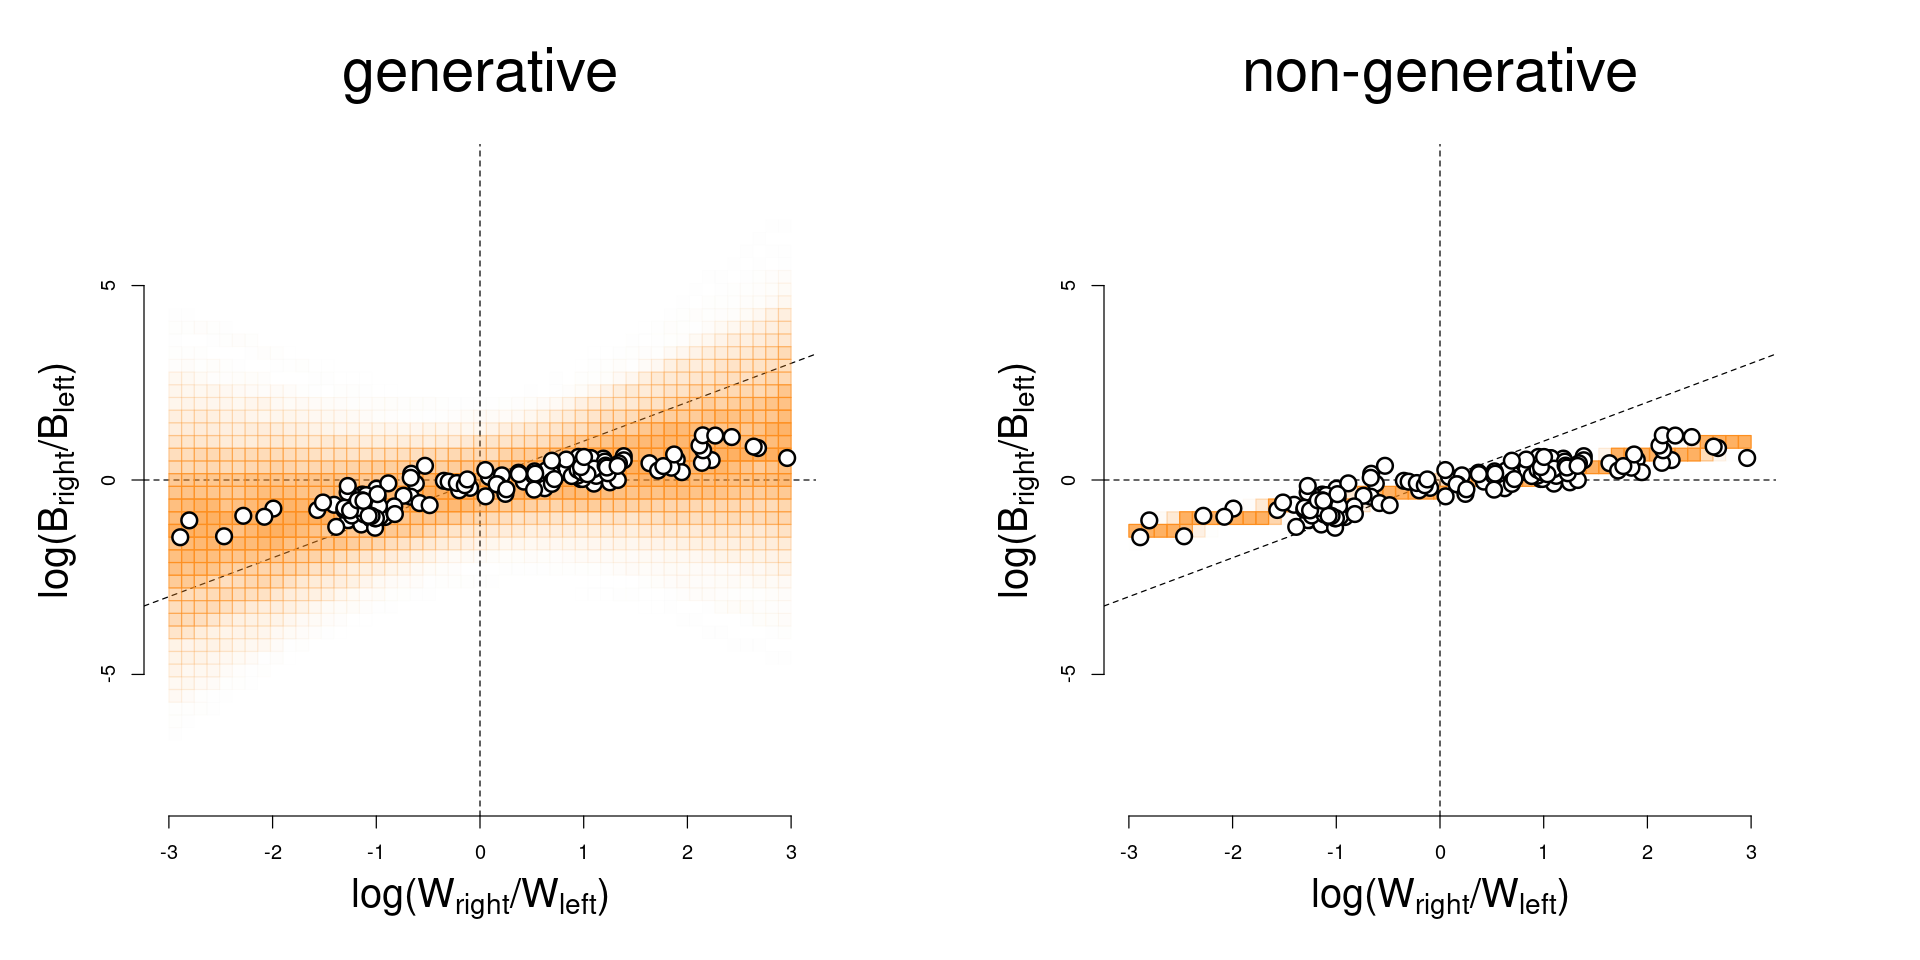

In [92]:
post_predictive <- function(nds,
                            prediction='posterior',
                            title=NULL){
    # nds <- nds_gen
#     if(prediction=='posterior'){
        pred_node <- nds$log_B_post
    
#         pred_node <- nds$log_B_prior
#     }
    plot(NULL,xlim=c(-3,3),ylim=c(-8,8),axes=F,ann=F)
    axis(1);axis(2)
    mtext(title,3,cex=3,line=2)
    mtext(expression(paste(log,'(',W[right],'/',W[left],')')),1,cex=2,line=3.5)
    mtext(expression(paste(log,'(',B[right],'/',B[left],')')),2,cex=2,line=2.5)
    abline(0,1,lty='dashed')
    abline(v=0,lty='dashed')
    abline(h=0,lty='dashed')

    # LINES
#     smpl <- sample(x = dim(nds$log_B_post)[1],size = 1000)
#     for(j in smpl){
#         abline(nds$alpha_post[j],
#                nds$beta_post[j],col='#62f06510')

#     }
#     abline(mean(nds$alpha_post),
#                mean(nds$beta_post),col='#ee0000',lwd=2)

    # GRADIENT
    # More model uncertainty
    n_brks <- 50
    x_brks <- seq(-3,3,length.out = n_brks)
    x_poly <- (x_brks[2]-x_brks[1])/2
    x_mids <- x_brks[1:(length(x_brks)-1)]+x_poly
    y_brks <- seq(-8,8,length.out = n_brks)
    y_poly <- (y_brks[2]-y_brks[1])/2
    y_mids <- y_brks[1:(length(y_brks)-1)]+y_poly
    for(i in 1:length(x_mids)){
        # Generate random samples at x_mids[i]
        ssize <- 1600
        distro <- NA
        for(j in 1:ssize){
            distro[j] <- nds$alpha_post[j]+nds$beta_post[j]*x_mids[i]
        }
        ht <- hist(distro,breaks = y_brks,plot=F)
        colz <- rgb(red = 253,
              green = 143,
              blue = 32,
              alpha=ht$density*(255*.7)/max(ht$density),
              maxColorValue = 255)
        bordz <- rgb(red = 253,
              green = 143,
              blue = 32,
              alpha=ht$density*(255)/max(ht$density),
              maxColorValue = 255)
        # Polygons
        for(k in 1:length(y_mids)){    
            polygon(x = c(x_mids[i]+(x_poly*c(-1,1,1,-1))),
                    y = c(y_mids[k]+(y_poly*c(-1,-1,1,1))),
                   border=bordz[k],col=colz[k])
#             points(x_mids[i],y_mids[k])
        }
    }
#     points(x_mids,y_mids)
    

    # POST-PRED
#     for(i in 1:nrow(bb_stable)){
# #         pred <- quantile(nds$log_B_post[,i],probs = c(0.025,0.975))
#         pred <- quantile(pred_node[,i],probs = c(0.025,0.975))
#         lines(rep(log(W_r[i]/W_l[i]),2),pred,lwd=5,col='#9525ba')
#     }

    # DATA
    points(log(bb_stable$n_reinf_right/bb_stable$n_reinf_left),
           log(bb_stable$n_resp_right/bb_stable$n_resp_left),
           pch=21,lwd=2,cex=1.75,bg='#ffffff')

}

options(repr.plot.width=16,repr.plot.height=8)
par(mar=rep(6,4))
layout(matrix(1:2,ncol=2))
post_predictive(nds_gen,title='generative')
post_predictive(nds_non_gen,title='non-generative')

In [58]:
?polygon

In [56]:
color

[1] "#FF000000" "#FF000000" "#FF0000FF" "#FF000000"

In [41]:
i <- length(x_mids)
j <- length(y_mids)
x_mids
x_poly
x_mids[i]+(x_poly*c(-1,1,1,-1))
y_mids
y_poly
y_mids[j]+(y_poly*c(-1,1,1,-1))

[1] -2.25 -0.75  0.75  2.25

[1] 0.75

[1] 1.5 3.0 3.0 1.5

[1] -7.5 -2.5  2.5  7.5

[1] 2.5

[1]  5 10 10  5

In [ ]:
  
    x_sup <- seq(-3,3,length.out = 20)
    for(i in length(x_sup)){
        ssize <- 100
        distro <- NA
        for(j in 1:ssize){
            distro[j] <- nds$alpha_post[j]+nds$beta_post[j]*x_sup[i]
        }
#         points(rep(x_sup,2),quantile(distro,probs=c(0.025,.975)))
    }


In [ ]:
quantile(distro,probs=c(0.025,.975))

In [ ]:
# bayes_non_gen
bayes_gen

In [ ]:
nds <- nds_gen
names(nds)

In [ ]:
head(nds$log_B)

In [ ]:
head(nds$log_W)

In [ ]:
mean_B <- apply(nds$log_B,FUN=mean,MARGIN=2)
mean_W <- apply(nds$log_W,FUN=mean,MARGIN=2)
plot(mean_W,mean_B,xlim=c(-3,3),ylim=c(-3,3));abline(0,1)

In [ ]:
col_prior <- '#ee770033'
col_post <- '#0077ee88'

options(repr.plot.width=12,repr.plot.height=12)
layout(matrix(1:6,ncol=2,byrow=T))
hist(nds_gen$alpha_post,xlim=c(-2,2),border=NA,col=col_post)
hist(nds_gen$alpha_prior,xlim=c(-2,2),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_non_gen$alpha_post,xlim=c(-2,2),border=NA,col=col_post)
hist(nds_non_gen$alpha_prior,xlim=c(-2,2),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_gen$beta_post,xlim=c(-2,2),border=NA,col=col_post)
hist(nds_gen$beta_prior,xlim=c(-2,2),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_non_gen$beta_post,xlim=c(-2,2),border=NA,col=col_post)
hist(nds_non_gen$beta_prior,xlim=c(-2,2),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_gen$sigma_post,xlim=c(0,10),border=NA,col=col_post)
hist(nds_gen$sigma_prior,xlim=c(0,10),border=NA,col=col_prior,add=T,breaks=100)

hist(nds_non_gen$sigma_post,xlim=c(0,10),border=NA,col=col_post)
hist(nds_non_gen$sigma_prior,xlim=c(0,10),border=NA,col=col_prior,add=T,breaks=100)

In [ ]:
names(nds_gen)

In [ ]:
plot(nds_gen$lambda_l_post,nds_gen$lambda_r_post,pch=16,col='#00000008')
points(B_l,B_r,pch=16,col='#ee0000aa')

In [ ]:
plot(nds_gen$alpha_post,nds_gen$beta_post,pch=16,col='#00000068')

In [ ]:
bivariate_plot <- function(x,y,x_bins=20,y_bins=20){

#     x_bins <- 50
#     y_bins <- 50
    x_brks <- seq(min(x,na.rm=T)-.5,max(x,na.rm=T)+.5,length.out=x_bins)
    y_brks <- seq(min(y,na.rm=T)-.5,max(y,na.rm=T)+.5,length.out=y_bins)
    x_mids <- x_brks+(1/2)*(x_brks[2]-x_brks[1])
    y_mids <- y_brks+(1/2)*(y_brks[2]-y_brks[1])
    count_matrix <- array(dim=c(length(x_mids),length(y_mids)))
    for(i in 1:length(x_mids)){
        for(j in 1:length(y_mids)){
            count_matrix[i,j] <- sum(x>=x_brks[i]&x<x_brks[i+1]&y>=y_brks[j]&y<y_brks[j+1])
            }
    }


    x_range <- max(x_brks)-min(x_brks)
    y_range <- max(y_brks)-min(y_brks)
    plot(NULL,
         xlim=c(min(x_brks),max(x_brks)+x_range*.5),
         ylim=c(min(y_brks),max(y_brks)+y_range*.5))
    x_margin <- apply(count_matrix,FUN=sum,MAR=1)
    y_margin <- apply(count_matrix,FUN=sum,MAR=2)
    lines(x_mids,max(y_brks)+x_margin*15,col='blue',lwd=2)
    lines(y_margin+max(x_brks),y_mids,col='orange',lwd=2)
    for(i in 1:length(x_mids)){
        for(j in 1:length(y_mids)){
            points(x_mids[i],y_mids[j],cex=count_matrix[i,j]*1,pch=22)
        }
    }

}

In [ ]:
options(repr.plot.width=15,repr.plot.height=43)
layout(matrix(1:12,ncol=2,byrow=T))
par(mar=rep(4,4))
# bivariate_plot(stable$n_reinf_right,
#                stable$n_resp_right)

# bivariate_plot(stable$n_reinf_left,
#                stable$n_resp_left)

for(bb in unique(stable$bird)){
    bb_dta <- subset(stable,bird==bb)
    
    bivariate_plot(bb_dta$n_reinf_right,
                   bb_dta$n_resp_right)
    mtext(bb,3)
    bivariate_plot(bb_dta$n_reinf_left,
                   bb_dta$n_resp_left)
    mtext(bb,3)

}

In [ ]:
pdf('bivariate_counts.pdf',width=6,height=18)
layout(matrix(1:12,ncol=2,byrow=T))
par(mar=rep(3,4))
# bivariate_plot(stable$n_reinf_right,
#                stable$n_resp_right)

# bivariate_plot(stable$n_reinf_left,
#                stable$n_resp_left)

for(bb in unique(stable$bird)){
    bb_dta <- subset(stable,bird==bb)
    
    bivariate_plot(bb_dta$n_reinf_right,
                   bb_dta$n_resp_right)
    mtext(bb,3)
    bivariate_plot(bb_dta$n_reinf_left,
                   bb_dta$n_resp_left)
    mtext(bb,3)

}
dev.off()

In [ ]:
palette <- c("#72e5ef","#f79302","#fd2c3b",
             "#b8e450","#4cf185","#9525ba")
colors <- NULL
cntr <- 0
for(bb in unique(stable$bird)){
    cntr <- cntr+1
    colors[which(stable$bird==bb)] <- paste(palette[cntr],'66',sep='')
}
stable$colors <- colors

options(repr.plot.width=15,repr.plot.height=10)
layout(matrix(1:6,ncol=3))
par(mar=c(7,7,2,2),oma=c(2,2,4,0),cex.axis=1.2)
for(bb in unique(stable$bird)){
    bb_stable <- subset(stable,bird==bb)
    plot(NULL,xlim=c(0,100),ylim=c(0,2000),axes=F,ann=F)
    axis(1);axis(2)
    points(bb_stable$n_reinf_right,
           bb_stable$n_resp_right,
           pch=21,bg=bb_stable$colors,cex=3.5)
    
    plot(NULL,xlim=c(0,100),ylim=c(0,2000),axes=F,ann=F)
    axis(1);axis(2)
    points(bb_stable$n_reinf_left,
           bb_stable$n_resp_left,
           pch=25,bg=bb_stable$colors,cex=3.5)
    mtext(bb,3,cex=1.5)
}
mtext('recompensas en derecha respecto de izquierda',1,line=0,cex=1.75,outer=T)
mtext('elecciones en derecha respecto de izquierda',2,line=0,cex=1.75,outer=T)
mtext('sesiones estables',3,line=2,cex=2,outer=T)